# Parallelize Python code with Dask Delayed

## General Python code

In [1]:
import csv

import requests
from dagster_dask import dask_executor
from dagster import get_dagster_logger, job, op, Out
from dagster import fs_io_manager

import numpy as np

import itkConfig
itkConfig.LazyLoading = False

import itk
import vtk
from itkwidgets import view
import icon_registration.itk_wrapper as itk_wrapper
import icon_registration.pretrained_models as pretrained_models
import matplotlib.pyplot as plt

import sys
sys.path.append("/data/OAI_analysis_2/oai_analysis_2")

import mesh_processing as mp
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

from dask import delayed, compute, visualize

In [2]:
from dask.distributed import Client, progress
client = Client(n_workers=1)
client

2022-04-15 17:30:30,907 - distributed.diskutils - INFO - Found stale lock file and directory '/home/pranjal.sahu/OAI/OAI_analysis/coiled-resources/dask-delayed/dask-worker-space/worker-iy_crcw3', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 16,Total memory: 125.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36517,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 125.73 GiB
Comm: tcp://127.0.0.1:33147,Total threads: 16
Dashboard: http://127.0.0.1:37795/status,Memory: 125.73 GiB
Nanny: tcp://127.0.0.1:36751,


In [3]:
# All Function Definitions

def download_data():
    os.system('girder-client --api-url https://data.kitware.com/api/v1 localsync 621a5d784acac99f426c143b OAIData')
    
    get_dagster_logger().info('Data download done')

    image_preprocessed = "./OAIData/atlas_image.nii.gz"
    atlas_image = "./OAIData/atlas_image.nii.gz"
    return image_preprocessed, atlas_image

#@delayed(nout=2)
def read_images(image_preprocessed, atlas_image):
    image_A = itk.imread(image_preprocessed, itk.D)
    image_B = itk.imread(atlas_image, itk.D)
    return image_A, image_B

#@delayed
def register_images(image_A, image_B):
    model = pretrained_models.OAI_knees_registration_model()
    model.to('cpu')

    # Register the images
    phi_AB, phi_BA = itk_wrapper.register_pair(model, image_A, image_B)

    get_dagster_logger().info('Image Registration Done')
    return phi_AB

#@delayed(nout=2)
def deform_probmap(phi_AB, image_A, image_B):
    fc_prob_file = '/data/OAI_analysis_2/OAIData/FC_probmap.nii.gz'
    tc_prob_file = '/data/OAI_analysis_2/OAIData/TC_probmap.nii.gz'

    FC_prob = itk.imread(fc_prob_file)
    TC_prob = itk.imread(tc_prob_file)

    interpolator = itk.LinearInterpolateImageFunction.New(image_A)
    warped_image_FC = itk.resample_image_filter(FC_prob, 
        transform=phi_AB, 
        interpolator=interpolator,
        size=itk.size(image_B),
        output_spacing=itk.spacing(image_B),
        output_direction=image_B.GetDirection(),
        output_origin=image_B.GetOrigin()
    )

    warped_image_TC = itk.resample_image_filter(TC_prob, 
        transform=phi_AB, 
        interpolator=interpolator,
        size=itk.size(image_B),
        output_spacing=itk.spacing(image_B),
        output_direction=image_B.GetDirection(),
        output_origin=image_B.GetOrigin()
    )

    get_dagster_logger().info('Image Deformation Done')
    return warped_image_FC, warped_image_TC

def get_itk_mesh(vtk_mesh):
    Dimension = 3
    PixelType = itk.D
    
    MeshType = itk.Mesh[PixelType, Dimension]
    itk_mesh = MeshType.New()
    
    # Get points array from VTK mesh
    points = vtk_mesh.GetPoints().GetData()
    points_numpy = np.array(points).flatten()
        
    polys = vtk_mesh.GetPolys().GetData()
    polys_numpy = np.array(polys).flatten()

    # Triangle Mesh
    vtk_cells_count = vtk_mesh.GetNumberOfPolys()
    polys_numpy = np.reshape(polys_numpy, [vtk_cells_count, Dimension+1])

    # Extracting only the points by removing first column that denotes the VTK cell type
    polys_numpy = polys_numpy[:, 1:]
    polys_numpy = polys_numpy.flatten().astype(np.uint64)

    # Get point data from VTK mesh to insert in ITK Mesh
    point_data_numpy = np.array(vtk_mesh.GetPointData().GetScalars())

    # Get cell data from VTK mesh to insert in ITK Mesh
    cell_data_numpy = np.array(vtk_mesh.GetCellData().GetScalars())
        
    itk_mesh.SetPoints(itk.vector_container_from_array(points_numpy))
    itk_mesh.SetCellsArray(itk.vector_container_from_array(polys_numpy), itk.CommonEnums.CellGeometry_TRIANGLE_CELL)
    itk_mesh.SetPointData(itk.vector_container_from_array(point_data_numpy))
    itk_mesh.SetCellData(itk.vector_container_from_array(cell_data_numpy))    
    return itk_mesh

#@delayed(nout=2)
def get_thickness_dask(image, mesh_type):
    inner_FC, outer_FC = mp.get_thickness_mesh(image, mesh_type=mesh_type)
    
    inner_FC_itk_mesh = get_itk_mesh(inner_FC)
    outer_FC_itk_mesh = get_itk_mesh(outer_FC)
    
    return inner_FC_itk_mesh, outer_FC_itk_mesh
    
#@delayed(nout=2)
def get_thickness(warped_image_FC, warped_image_TC):
    distance_inner_FC, distance_outer_FC = mp.get_thickness_mesh(warped_image_FC, mesh_type='FC')
    distance_inner_TC, distance_outer_TC = mp.get_thickness_mesh(warped_image_TC, mesh_type='TC')

    get_dagster_logger().info('Thickness Computation Done')

    return distance_inner_FC, distance_inner_TC

#@delayed(nout=2)
def get_paths():
    image_preprocessed = "/data/OAI_analysis_2/OAIData/atlas_image.nii.gz"
    atlas_image = "/data/OAI_analysis_2/OAIData/atlas_image.nii.gz"

    return image_preprocessed, atlas_image

#@delayed(nout=2)
def register_and_deform(image_A, image_B):
    phi_AB                               = register_images(image_A=image_A, image_B=image_B)
    warped_image_FC, warped_image_TC     = deform_probmap(phi_AB=phi_AB, image_A=image_A, image_B=image_B)
    return warped_image_FC, warped_image_TC

#@delayed
def entire_job(warped_image_FC, warped_image_TC):
    distance_inner_FC, distance_inner_TC = get_thickness(warped_image_FC=warped_image_FC, warped_image_TC=warped_image_TC)

    writer1 = vtk.vtkPolyDataWriter()
    writer1.SetFileName('distance_inner_FC.vtk')
    writer1.SetInputData(distance_inner_FC)
    writer1.Update()

    writer2 = vtk.vtkPolyDataWriter()
    writer2.SetFileName('distance_inner_TC.vtk')
    writer2.SetInputData(distance_inner_TC)
    writer2.Update()

#@delayed
def thickness_compute():
    #image_preprocessed, atlas_image = download_data()
    #image_preprocessed = "./OAIData/atlas_image.nii.gz"
    #atlas_image = "./OAIData/atlas_image.nii.gz"

    #image_preprocessed, atlas_image =  get_paths()
    
    # In ITKrc3 images can be serialized
    image_preprocessed, atlas_image   = get_paths()
    image_A, image_B                  = read_images(image_preprocessed, atlas_image)
    warped_image_FC, warped_image_TC  = register_and_deform(image_A, image_B)
    
    distance_inner_FC, distance_outer_FC = mp.get_thickness_mesh(warped_image_FC, mesh_type='FC')
    distance_inner_TC, distance_outer_TC = mp.get_thickness_mesh(warped_image_TC, mesh_type='TC')
    
    return distance_inner_FC, distance_inner_TC
    # Rest all the processing is done here
    # After mesh serialization this can be splitted into smaller components
    # Also working on Transform serialization
    #entire_job(warped_image_FC, warped_image_TC)

## Dask Delayed

Open the dashboards!

In [4]:
image_preprocessed, atlas_image   = get_paths()

image_A, image_B                  = read_images(image_preprocessed, atlas_image)
warped_image_FC, warped_image_TC  = register_and_deform(image_A, image_B)

distance_inner_FC, distance_outer_FC = get_thickness_dask(warped_image_FC, mesh_type='FC')
distance_inner_TC, distance_outer_TC = get_thickness_dask(warped_image_TC, mesh_type='TC')

all_distance = [distance_inner_FC, distance_inner_TC]

marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19


In [6]:
itk.meshwrite(distance_inner_FC, 'itk_distance_inner_FC.vtk')
itk.meshwrite(distance_inner_TC, 'itk_distance_inner_TC.vtk')

**Note:** Don't do `delayed(inc(i))`

In [9]:
import itkwidgets

In [7]:
a1 = vtk.vtkPolyDataReader()
a1.SetFileName('/home/pranjal.sahu/OAI/OAI_analysis/coiled-resources/dask-delayed/itk_distance_inner_FC.vtk')
a1.Update()
a1 = a1.GetOutput()

#a1.SetFileName('/home/pranjal.sahu/OAI/OAI_analysis/coiled-resources/dask-delayed/itk_distance_inner_FC.vtk')

In [10]:
itkwidgets.view(geometries=[a1])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

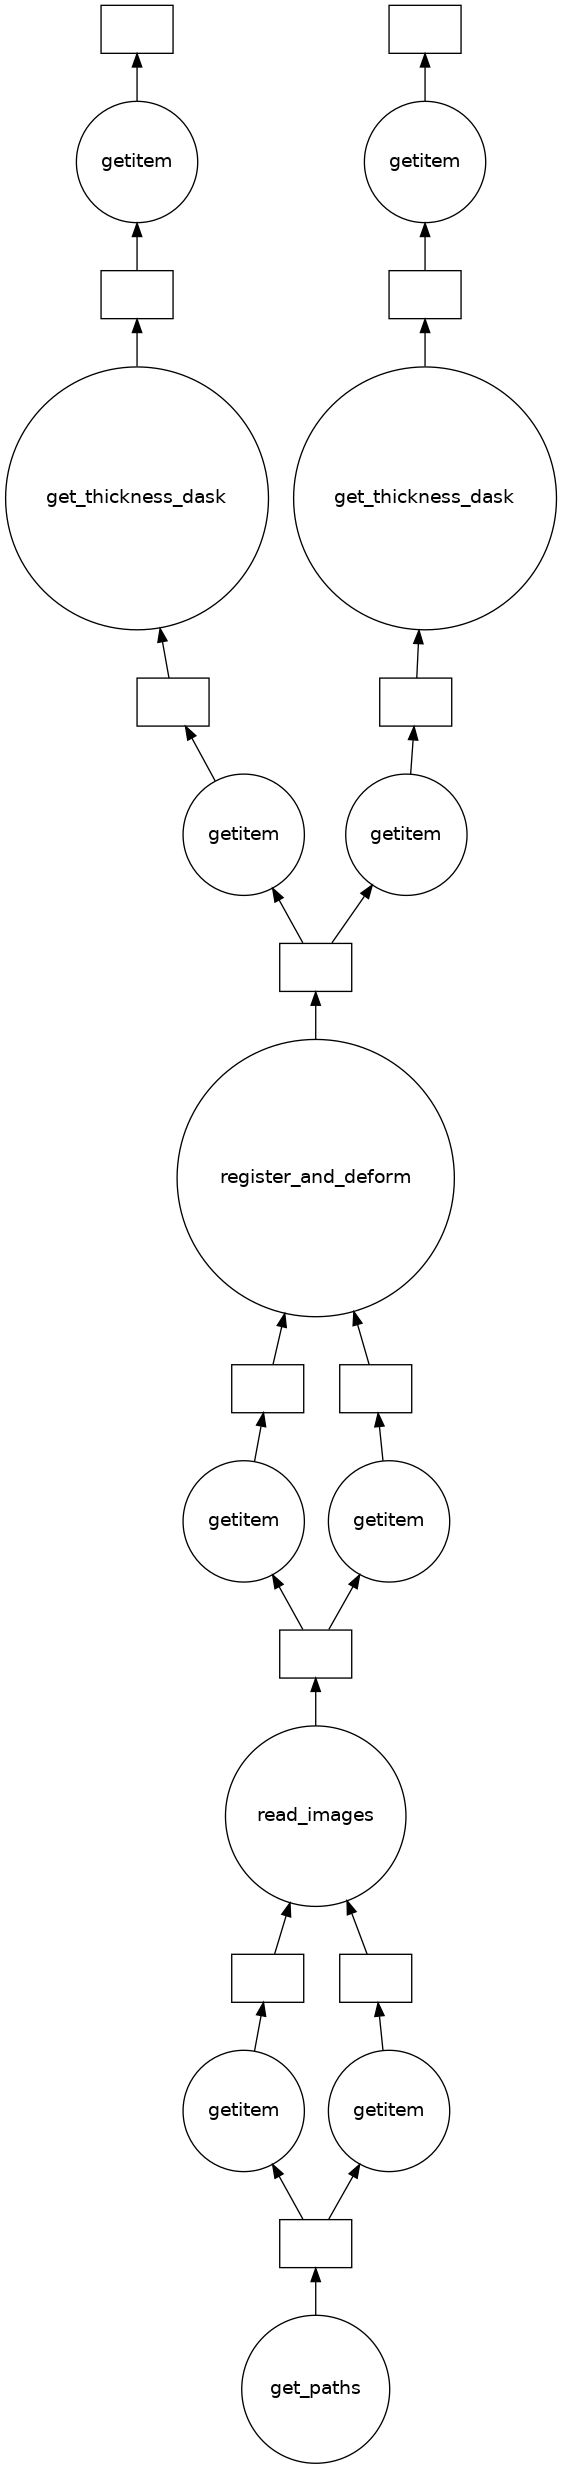

In [5]:
visualize(all_distance)

**Note:** Try to minimize computing.

In [ ]:
%%time

l = compute(all_distance)

### Alternatively...

In [14]:
@delayed
def inc(x):
    sleep(1)
    return x + 1

@delayed
def dec(x):
    sleep(1)
    return x - 1

@delayed
def add(x, y):
    sleep(1)
    return x + y

Or:

**Note:** Dask DataFrame is better for parallelizing pandas